In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage ,fcluster
from collections import Counter
from sklearn.datasets.samples_generator import make_blobs
from sklearn import preprocessing
from sklearn.metrics.cluster import adjusted_rand_score
import itertools
import random
from scipy.spatial import distance as ssd
from tqdm import tqdm
import scipy
import scipy.sparse 
from scipy.stats import pearsonr
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph 
from scipy.sparse.linalg import expm
from scipy.linalg import solve_banded
from scipy.spatial.distance import pdist
import scipy.spatial.distance
import math
from sklearn.metrics.pairwise import euclidean_distances
import sklearn
import os.path
plt.ion()
plt.show()

In [2]:
def generateData(n_clusters=3,
                 n_samples=20,
                 n_definingfeatures=2,
                 n_shuffle_defining_features=0,
                 n_uniform_features=0,
                 n_normal_features=0):
    """
    This method generates a synthetic dataset with the following properties:
    - n_clusters represents the number of classes, n_samples the number of dimensions. 
    - n_definingfeatures represents the number of features allowing to separate the data and retrieve the 
    generated n_clusters. The defining features are generated with a gaussian distribution (make_blobs)
    - n_shuffle_defining_features shuffles per class the clusters with uniform data, thus creating columns
    When 0 the clusters will have a gaussian distribution across all features
    - n_uniform_features governs the number of non-discriminative columns with an uniform distribution
    - n_uniform_features governs the number of non-discriminative columns with a gaussian distribution
    """
    data_x, data_y = make_blobs(n_samples=n_samples, centers=n_clusters, random_state=42, n_features=n_definingfeatures, 
                               cluster_std=0.05, center_box=(0, 1))

    n_non_shuffle_dims= np.arange(0,n_definingfeatures-n_shuffle_defining_features)

    non_shuffled_data = data_x[:, n_non_shuffle_dims ]
    shuffle_data = data_x[:, len(n_non_shuffle_dims): ]

    uniform_shuffle = np.random.uniform(low=0, high=1, size=(n_samples, n_shuffle_defining_features,))
    # shuffle the dimensions for each cluster
    dims = np.repeat(np.arange(n_shuffle_defining_features *2).reshape(1,-1),n_clusters, axis=0)
    
    for i in range(n_clusters):
        np.random.shuffle(dims[i])
    print(dims)
    cluster_shuffled_features = np.stack([dims[i] for i in data_y])
    mixed_data_to_shuffle =np.hstack([shuffle_data, uniform_shuffle])

    mixed_shuffled_data = np.zeros_like(mixed_data_to_shuffle)
    for i in range(len(mixed_data_to_shuffle)):
        mixed_shuffled_data[i] = mixed_data_to_shuffle[i, :][cluster_shuffled_features[i]]

    uniform_features = np.random.uniform(low=0.1, high=0.9, size=(n_samples, n_uniform_features,))
    normal_features = np.random.normal(size=(n_samples, n_normal_features,))


    data = np.concatenate([non_shuffled_data, mixed_shuffled_data, uniform_features,normal_features], axis=1)
    print(f'discriminative non_shuffled_data {non_shuffled_data.shape}, disc mixed_shuffled_data {mixed_shuffled_data.shape} ' +
         f'uniform_features {uniform_features.shape}, normal_features {normal_features.shape}')
    data = preprocessing.MinMaxScaler().fit_transform(data)
    return data, data_y

## Generate data having a combination of distributions
The goal is to generate a dataset with a more complicated data structure, mixing gausian distributions with uniform columns and a shuffled mix of the 2:

In [3]:
n_clusters = 4
n_samples=200
n_definingfeatures=5
n_shuffle_defining_features=3
n_uniform_features=1
n_normal_features=1
minClusterSize = 10 # parameter used for pruning the tree

data, truth = generateData(n_clusters=n_clusters,
                 n_samples=n_samples,
                 n_definingfeatures=n_definingfeatures,
                 n_shuffle_defining_features=n_shuffle_defining_features,
                 n_uniform_features=n_uniform_features,
                 n_normal_features=n_normal_features)
N, M = data.shape
print(Counter(truth), data.shape)

[[1 0 2 4 3 5]
 [4 1 3 0 2 5]
 [4 5 1 3 0 2]
 [5 2 3 1 0 4]]
discriminative non_shuffled_data (200, 2), disc mixed_shuffled_data (200, 6) uniform_features (200, 1), normal_features (200, 1)
Counter({2: 50, 0: 50, 1: 50, 3: 50}) (200, 10)


Plot input data

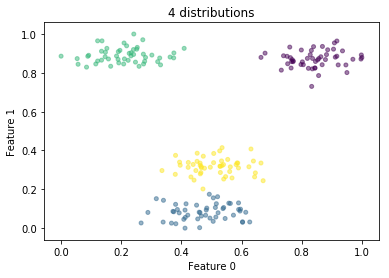

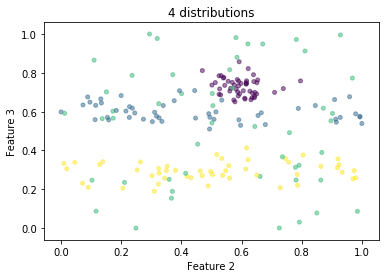

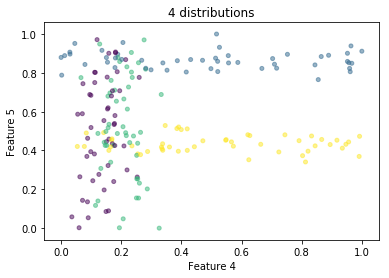

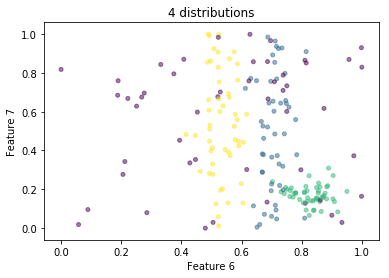

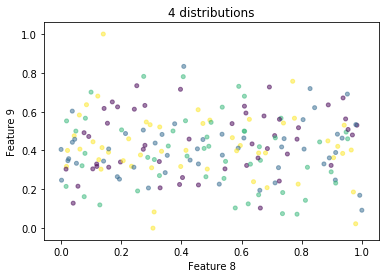

In [4]:
for i in range(0,data.shape[1]//2):
    plt.figure()
    plt.scatter(data[:, 2*i], data[:, 2*i+1], s=16, c = truth, cmap = 'viridis', alpha=.5)
    plt.title(f"{n_clusters} distributions")
    plt.xlabel(f"Feature {2*i}")
    plt.ylabel(f"Feature {2*i+1}");

### Assess performance of traditional clustering methods

In [5]:
pred = KMeans(n_clusters= n_clusters).fit(data).labels_
print(adjusted_rand_score(truth, pred))

0.6593410656383218
0.9734739568173101


## Mean absolute difference

In [6]:
mad = np.sum(np.abs(data -np.mean(data, axis =0 )), axis = 0)/data.shape[0]

<BarContainer object of 10 artists>

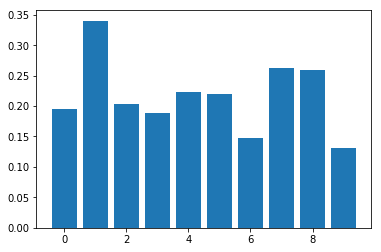

In [7]:
plt.bar(np.arange(data.shape[1]),mad)

## Dispesion

In [8]:
def dispersion(data):
    data = data +1 #avoid 0 division
    aritmeticMean = np.mean(data, axis =0 )
    geometricMean = np.power(np.prod(data, axis =0 ),1/data.shape[0])
    R = aritmeticMean/geometricMean
    return R

In [9]:
R = dispersion(data)

<BarContainer object of 10 artists>

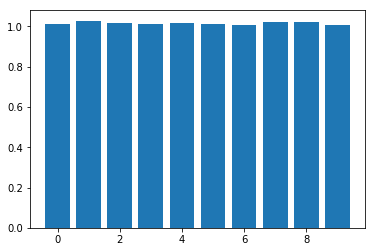

In [10]:
plt.bar(np.arange(data.shape[1]),R)

## Laplacian Score
Implementation from https://github.com/jundongl/scikit-feature/blob/master/skfeature/function/similarity_based/lap_score.py

In [11]:
def construct_W(X, neighbour_size = 5, t = 1):
    n_samples, n_features = np.shape(X)
    S=kneighbors_graph(X, neighbour_size+1, mode='distance',metric='euclidean') #sqecludian distance works only with mode=connectivity  results were absurd
    S = (-1*(S*S))/(2*t*t)
    S=S.tocsc()
    S=expm(S) # exponential
    S=S.tocsr()
    #[1]  M. Belkin and P. Niyogi, “Laplacian Eigenmaps and Spectral Techniques for Embedding and Clustering,” Advances in Neural Information Processing Systems,
    #Vol. 14, 2001. Following the paper to make the weights matrix symmetrix we use this method
    bigger = np.transpose(S) > S
    S = S - S.multiply(bigger) + np.transpose(S).multiply(bigger)
    return S

def LaplacianScore(X, neighbour_size = 5,  t = 1):
    W = construct_W(X,t=t,neighbour_size=neighbour_size)
    n_samples, n_features = np.shape(X)
    
    #construct the diagonal matrix
    D=np.array(W.sum(axis=1))
    D = scipy.sparse.diags(np.transpose(D), [0])
    #construct graph Laplacian L
    L=D-W.toarray()

    #construct 1= [1,···,1]' 
    I=np.ones((n_samples,n_features))

    #construct fr' => fr= [fr1,...,frn]'
    Xt = np.transpose(X)

    #construct fr^=fr-(frt D I/It D I)I
    t=np.matmul(np.matmul(Xt,D.toarray()),I)/np.matmul(np.matmul(np.transpose(I),D.toarray()),I)
    t=t[:,0]
    t=np.tile(t,(n_samples,1))
    fr=X-t

    #Compute Laplacian Score
    fr_t=np.transpose(fr)
    Lr=np.matmul(np.matmul(fr_t,L),fr)/np.matmul(np.dot(fr_t,D.toarray()),fr)

    return np.diag(Lr)

In [12]:
ls =LaplacianScore(data)

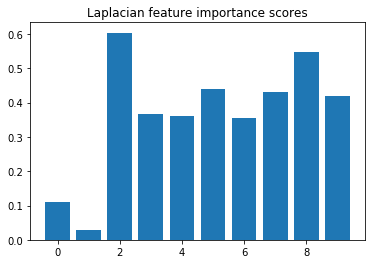

In [22]:
plt.title('Laplacian feature importance scores')
plt.bar(np.arange(data.shape[1]),ls);

## Distance based entropy

In [14]:
def distanceEntropy(d, mu = 0.5, beta=10):
    """
    As per: An Unsupervised Feature Selection Algorithm: Laplacian Score Combined with
    Distance-based Entropy Measure, Rongye Liu 
    """
    if d<=mu:
        result = (np.exp(beta * d) - np.exp(0))/(np.exp(beta * mu) - np.exp(0))
    else:
        result = (np.exp(beta * (1-d) )- np.exp(0))/(np.exp(beta *(1- mu)) - np.exp(0))              
    return result

In [15]:
def lse(data, ls):
    """
    This method takes as input a dataset, its laplacian scores for all features
    and applies distance based entropy feature selection in order to identify
    the best subset of features in the laplacian sense.
    """
    orderedFeatures = np.argsort(ls)
    scores = {}
    for i in range (2,len(ls)):
        selectedFeatures = orderedFeatures[:i]
        selectedFeaturesDataset = data[:, selectedFeatures]
        d =sklearn.metrics.pairwise_distances(selectedFeaturesDataset, metric = 'euclidean' )
        beta =10
        mu = 0.5

        d = preprocessing.MinMaxScaler().fit_transform(d)
        e = np.vectorize(distanceEntropy)(d) 
        e = preprocessing.MinMaxScaler().fit_transform(e)
        totalEntropy= np.sum(e)
        scores[i] = totalEntropy
    bestFeatures = orderedFeatures[:list(scores.keys())[np.argmin(scores.values())]]
    return bestFeatures

Best features:

In [17]:
selectedFeatures = lse(data, ls)
selectedFeatures

array([1, 0], dtype=int64)

## Re-assess performance using only most relevant features

In [21]:
pred = KMeans(n_clusters= n_clusters).fit(data[:,selectedFeatures]).labels_
print(adjusted_rand_score(truth, pred))

0.986598879940902
